In [125]:
!pip3 install emoji
!pip install plotly.express
!pip install regex
!pip install wordcloud

In [126]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px

import re
import regex
from emoji import EMOJI_DATA
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

# Define necessary functions

In [127]:
# Regex pattern to identify the start of each line in the text file with date and time
def StartsWithDateAndTime(s):
    # Example: '21/2/2021 11:27 a.m. - ... '
    pattern = r'^((?:[1-9]|1[0-9]|2[0-9]|3[0-1])\/(?:[1-9]|1[0-2])\/(?:2[0-9]{3})\s(?:[0-9]|1[0-2]):(?:[0-9]{2})\s*(?:AM|PM|a\.?m\.?|p\.?m\.?)|(?:[1-9]|1[0-2])\/(?:[1-9]|1[0-9]|2[0-9]|3[0-1])\/(?:[0-9]{2}),\s(?:[0-9]|1[0-2]):(?:[0-9]{2})\s*(?:AM|PM))\s*-\s*'
    result = re.match(pattern, s)  # Verify if each line in the text matches the date and time pattern
    if result:
        return True
    return False

# Pattern to find group members in the text
def FindMember(s):
    patterns = [
        '([\w]+):',                          # Name
        '([\w]+[\s]+[\(]+[\w]+[\)]+):',      # Name (Nickname)
        '([\w]+[\s]+[\w]+):',                # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',      # First Name + Middle Name + Last Name
        '([+]\d{2} \d{3} \d{3} \d{3}):',     # Phone number (Peru)
        '([\w]+)[\u263a-\U0001f999]+:',      # Name + Emoji
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)  # Verify if each line in the text matches the member pattern
    if result:
        return True
    return False

# Split the parts of each line in the text: Date, Time, Member, and Message
def GetParts(line):
    # Example: '21/2/2021 11:27 a.m. - Cesar: We should all learn to analyze data'
    splitLine = line.split(' - ')
    DateTime = splitLine[0]                 # '21/2/2021 11:27 a.m.'
    splitDateTime = DateTime.split(' ')
    Date = splitDateTime[0]                 # '21/2/2021'
    Time = ' '.join(splitDateTime[1:])      # '11:27 a.m.'
    Message = ' '.join(splitLine[1:])       # 'Cesar: We should all learn to analyze data'
    if FindMember(Message):
        splitMessage = Message.split(': ')
        Member = splitMessage[0]            # 'Cesar'
        Message = ' '.join(splitMessage[1:]) # 'We should all learn to analyze data'
    else:
        Member = None
    return Date, Time, Member, Message

# Parse date to work with Spanish/English formats
def parse_date(date_str):
    # Remove any trailing characters after the year (like comma and space)
    date_str = date_str.split(',')[0]

    for fmt in ("%d/%m/%Y", "%m/%d/%y"):
        try:
            return pd.to_datetime(date_str, format=fmt)
        except ValueError:
            continue
    raise ValueError(f"Unable to parse date: {date_str}")

# Obtain the dataframe using the text file and the defined functions

# Statistics of messages, multimedia, emojis, and links

### Total number of messages, multimedia, emojis, and links sent

In [128]:
# Read the text file downloaded from the WhatsApp chat
ChatPath = 'Chat.txt'

# List to store the data (Date, Time, Member, Message) from each line of the text file
DataList = []
with open(ChatPath, encoding="utf-8") as fp:
    fp.readline() # Remove the first row related to end-to-end encryption
    CheckMessage = [] # List to check that there are no empty messages
    Date, Time, Member = None, None, None
    while True:
        line = fp.readline()
        if not line: 
            break
        line = line.strip()
        if StartsWithDateAndTime(line): # If each line of the text matches the date and time pattern
            if len(CheckMessage) > 0:
                # Add a list element containing the data to the 'DataList'
                DataList.append([Date, Time, Member, ' '.join(CheckMessage)])
            CheckMessage.clear()
            Date, Time, Member, Message = GetParts(line) # Get data from each line of the text
            CheckMessage.append(Message)
        else:
            CheckMessage.append(line)

# Convert the list with the data to a dataframe
df = pd.DataFrame(DataList, columns=['Date', 'Time', 'Member', 'Message'])

# Change the Date column to datetime format
df['Date'] = df['Date'].apply(parse_date)

# Remove potential empty fields from the dataframe
# and those that are not messages such as changing the group subject or adding someone
df = df.dropna()

# Reset the index
df.reset_index(drop=True, inplace=True)
df

,Date,Time,Member,Message
0,2023-09-19,5:43 PM,Santiago Salamanca BF,<Media omitted>
1,2023-09-19,5:45 PM,Viviana Blankfactor,Masters dónde andan?
2,2023-09-19,5:47 PM,Gustavo BF,Estamos en sarku
3,2023-09-19,5:48 PM,Gustavo BF,location https://maps.google.com/?q=6.19769620...
4,2023-09-19,5:48 PM,Viviana Blankfactor,No conozco este centro comercial.. Piso? Lado?
...,...,...,...,...
588,2023-11-26,10:19 AM,Santiago Salamanca BF,"Hola Master, Hace poco solicite uno enviándole..."
589,2023-11-26,10:23 AM,Gonza,Nada. Ya nos vimos en la necesidad de adquirir...
590,2023-11-26,10:51 AM,Cesar Cadavid,"Tal cual así es, le entró 🤝"
591,2023-11-30,1:21 AM,Cesar Cadavid,https://www.instagram.com/reel/Cw3jc_xg3PN/?ig...


In [129]:
def GetEmojis(text):
    # Regex pattern to match emojis
    emoji_pattern = regex.compile("[\U0001F300-\U0001F5FF"  # symbols & pictographs
                                  "\U0001F600-\U0001F64F"  # emoticons
                                  "\U0001F680-\U0001F6FF"  # transport & map symbols
                                  "\U0001F700-\U0001F77F"  # alchemical symbols
                                  "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                                  "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                                  "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                                  "\U0001FA00-\U0001FA6F"  # Chess Symbols
                                  "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                                  "\U00002702-\U000027B0"  # Dingbats
                                  "\U000024C2-\U0001F251"  # Enclosed characters
                                  "]+", flags=regex.UNICODE)

    # Find all emojis in the text
    return emoji_pattern.findall(text)

# Get the total number of messages
total_messages = df.shape[0] 

# Get the number of multimedia files sent
multimedia_messages = df[df['Message'] == '<Media omitted>'].shape[0] 

# Get the number of emojis sent
df['Emojis'] = df['Message'].apply(GetEmojis) # Add 'Emojis' column
emojis_count = sum(df['Emojis'].str.len())

# Get the number of links sent
url_pattern = r'(https?://\S+)'
df['URLs'] = df.Message.apply(lambda x: re.findall(url_pattern, x)).str.len() # Add 'URLs' column
links_count = np.sum(df.URLs)

# Pass all data to a dictionary
statistics_dict = {'Type': ['Messages', 'Multimedia', 'Emojis', 'Links'],
        'Quantity': [total_messages, multimedia_messages, emojis_count, links_count]
        }

# Convert dictionary to dataframe
statistics_df = pd.DataFrame(statistics_dict, columns = ['Type', 'Quantity'])

# Set the 'Type' column as the index
statistics_df = statistics_df.set_index('Type')
statistics_df

,Quantity
Type,
Messages,593
Multimedia,104
Emojis,85
Links,7


In [130]:
# Main dataframe with 'Emojis' and 'URLs' columns added
df.tail(10)

,Date,Time,Member,Message,Emojis,URLs
583,2023-11-24,9:26 AM,Cesar Cadavid,Y acá en Medellín jugamos incluso peor q en Bo...,[],0
584,2023-11-24,9:29 AM,Cesar Cadavid,Ya nos va a apuñalar ... Porque eso de enviar ...,[],0
585,2023-11-24,9:30 AM,Cesar Cadavid,<Media omitted>,[],0
586,2023-11-25,6:31 AM,Gonza,Jum!,[],0
587,2023-11-26,10:01 AM,Gonza,"Masters, buenos días. ¿Ya cambió el medio por ...",[],0
588,2023-11-26,10:19 AM,Santiago Salamanca BF,"Hola Master, Hace poco solicite uno enviándole...",[],0
589,2023-11-26,10:23 AM,Gonza,Nada. Ya nos vimos en la necesidad de adquirir...,[],0
590,2023-11-26,10:51 AM,Cesar Cadavid,"Tal cual así es, le entró 🤝",[🤝],0
591,2023-11-30,1:21 AM,Cesar Cadavid,https://www.instagram.com/reel/Cw3jc_xg3PN/?ig...,[🤔🤔🤔],1
592,2023-11-30,2:14 AM,Gonza,"Jum, demás. Yo no sé 🤣",[🤣],0


### Most Used Emojis

In [131]:
# Get the most used emojis and their counts in the group chat from the dataframe
emoji_list = list([a for b in df.Emojis for a in b])
emoji_dict = dict(Counter(emoji_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)

# Convert the dictionary to a dataframe
emoji_df = pd.DataFrame(emoji_dict, columns=['Emoji', 'Count'])

# Set the 'Emoji' column as the index
emoji_df = emoji_df.set_index('Emoji')

print('Number of unique emojis used: ', len(emoji_df), '\n')
emoji_df.head(10)

Number of unique emojis used:  64 



,Count
Emoji,
😂🤣😂,8
😂,4
🤣,4
😂🤣,3
😂😂😂😂,2
🥲,2
🙏🏻,2
💅,2
🤣😂🤣,2


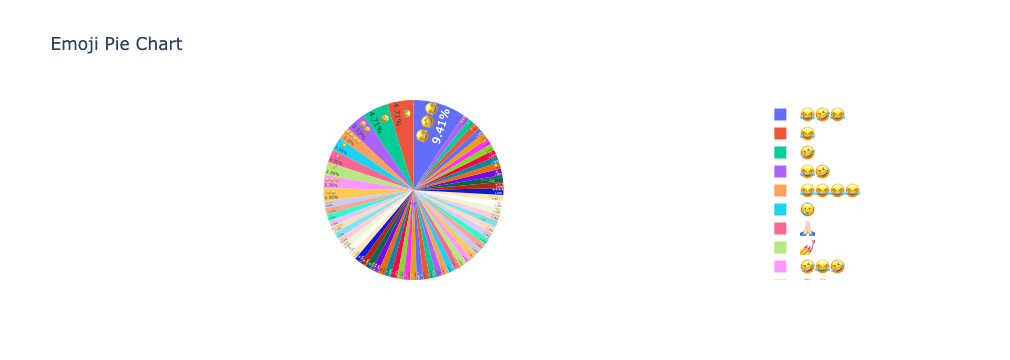

In [132]:
# Plot a pie chart of the most used emojis
fig = px.pie(emoji_df, values='Count', names=emoji_df.index, title='Emoji Pie Chart')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

# When adding Jupyter Notebook or IPython Notebook files with a .ipynb extension on GitHub,
# they will be displayed as static HTML files in your repository, but the plot charts are interactive

# Statistics of the group members

### Most Active Members

In [133]:
# Identify all members of the group
df.Member.unique()

array(['Santiago Salamanca BF', 'Viviana Blankfactor', 'Gustavo BF',
       'Gonza', 'Oscar Virgüez BF', 'Cesar Cadavid', 'Adrian Trujillo BF'],
      dtype=object)

In [134]:
# Determine the most active members of the group
df_ActiveMembers = df.groupby('Member')['Message'].count().sort_values(ascending=False).to_frame()
df_ActiveMembers.reset_index(inplace=True)
df_ActiveMembers.index = np.arange(1, len(df_ActiveMembers)+1)
df_ActiveMembers.head(10)

,Member,Message
1,Cesar Cadavid,210
2,Gonza,145
3,Oscar Virgüez BF,70
4,Viviana Blankfactor,65
5,Adrian Trujillo BF,61
6,Gustavo BF,32
7,Santiago Salamanca BF,10


### Statistics by Member

In [135]:
# Separate messages (excluding multimedia) and multimedia (stickers, photos, videos)
multimedia_df = df[df['Message'] == '<Multimedia omitted>']
messages_df = df.drop(multimedia_df.index)

# Count the number of letters and words per message
messages_df['Letters'] = messages_df['Message'].apply(lambda s: len(s))
messages_df['Words'] = messages_df['Message'].apply(lambda s: len(s.split(' ')))
messages_df.tail()

,Date,Time,Member,Message,Emojis,URLs,Letters,Words
588,2023-11-26,10:19 AM,Santiago Salamanca BF,"Hola Master, Hace poco solicite uno enviándole...",[],0,96,20
589,2023-11-26,10:23 AM,Gonza,Nada. Ya nos vimos en la necesidad de adquirir...,[],0,99,19
590,2023-11-26,10:51 AM,Cesar Cadavid,"Tal cual así es, le entró 🤝",[🤝],0,27,7
591,2023-11-30,1:21 AM,Cesar Cadavid,https://www.instagram.com/reel/Cw3jc_xg3PN/?ig...,[🤔🤔🤔],1,106,9
592,2023-11-30,2:14 AM,Gonza,"Jum, demás. Yo no sé 🤣",[🤣],0,22,6


In [136]:
# Get all members
members = messages_df.Member.unique()

# Create a dictionary to store all the data
dictionary = {}

for i in range(len(members)):
    list_data = []
    # Filter messages from a specific member
    member_df = messages_df[messages_df['Member'] == members[i]]

    # Add to the list the total number of messages sent
    list_data.append(member_df.shape[0])

    # Add to the list the number of words per total messages (words per message)
    words_per_msg = (np.sum(member_df['Words'])) / member_df.shape[0]
    list_data.append(words_per_msg)

    # Add to the list the number of multimedia messages sent
    multimedia = multimedia_df[multimedia_df['Member'] == members[i]].shape[0]
    list_data.append(multimedia)

    # Add to the list the total number of emojis sent
    emojis = sum(member_df['Emojis'].str.len())
    list_data.append(emojis)

    # Add to the list the total number of links sent
    links = sum(member_df['URLs'])
    list_data.append(links)

    # Assign the list as the value to the dictionary key
    dictionary[members[i]] = list_data
print(dictionary)

{'Santiago Salamanca BF': [10, 6.5, 0, 3, 0], 'Viviana Blankfactor': [65, 7.8307692307692305, 0, 13, 0], 'Gustavo BF': [32, 4.625, 0, 8, 1], 'Gonza': [145, 6.9862068965517246, 0, 7, 1], 'Oscar Virgüez BF': [70, 4.057142857142857, 0, 13, 1], 'Cesar Cadavid': [210, 8.914285714285715, 0, 19, 4], 'Adrian Trujillo BF': [61, 4.622950819672131, 0, 22, 0]}


In [137]:
# Convert from dictionary to dataframe
member_stats_df = pd.DataFrame.from_dict(dictionary)

# Change the index to the added column 'Statistics'
statistics = ['Messages', 'Words per message', 'Multimedia', 'Emojis', 'Links']
member_stats_df['Statistics'] = statistics
member_stats_df.set_index('Statistics', inplace=True)

# Transpose the dataframe
member_stats_df = member_stats_df.T

# Convert columns Messages, Multimedia, Emojis, and Links to integer
member_stats_df['Messages'] = member_stats_df['Messages'].apply(int)
member_stats_df['Multimedia'] = member_stats_df['Multimedia'].apply(int)
member_stats_df['Emojis'] = member_stats_df['Emojis'].apply(int)
member_stats_df['Links'] = member_stats_df['Links'].apply(int)
member_stats_df.head(10)

Statistics,Messages,Words per message,Multimedia,Emojis,Links
Santiago Salamanca BF,10,6.500000,0,3,0
Viviana Blankfactor,65,7.830769,0,13,0
Gustavo BF,32,4.625000,0,8,1
Gonza,145,6.986207,0,7,1
Oscar Virgüez BF,70,4.057143,0,13,1
Cesar Cadavid,210,8.914286,0,19,4
Adrian Trujillo BF,61,4.622951,0,22,0


# Statistics on the group's behavior

### Days and Times When the Group Was Most Active

Text(0, 0.5, 'Date')

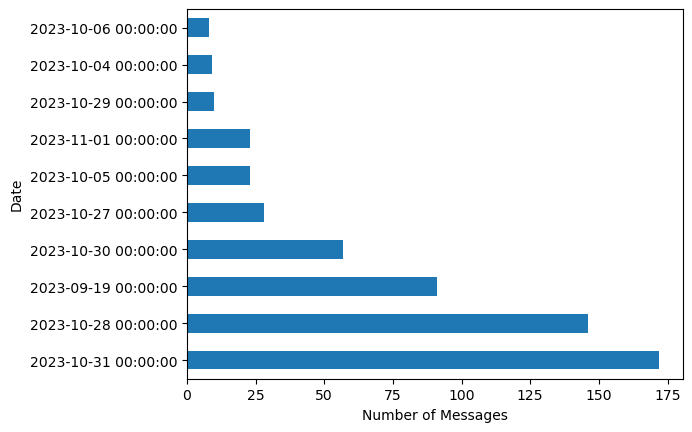

In [138]:
# Determine the most active days of the group
df['Date'].value_counts().head(10).plot.barh() # Plot the top 10 days
plt.xlabel('Number of Messages')
plt.ylabel('Date')

Text(0, 0.5, 'Time')

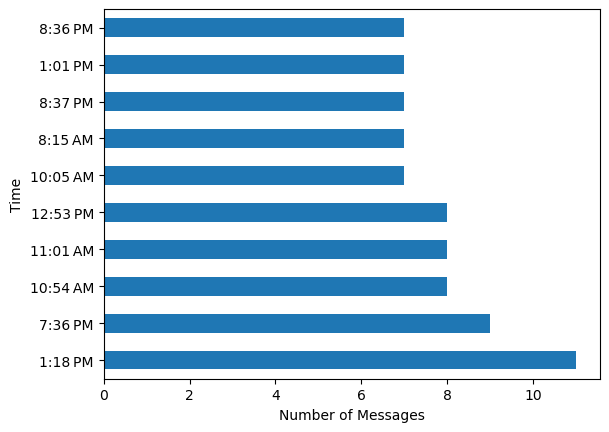

In [139]:
# Determine the times when the group is most active
df['Time'].value_counts().head(10).plot.barh()
plt.xlabel('Number of Messages')
plt.ylabel('Time')

### Word Cloud of the Most Used Words by the Group

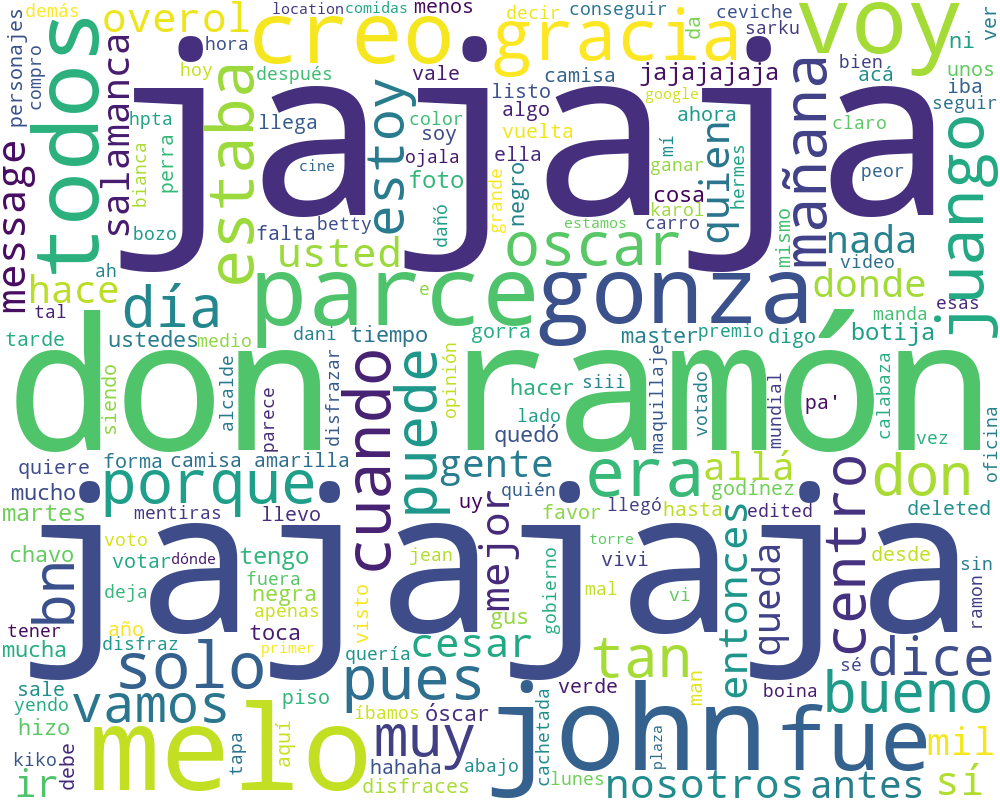

In [140]:
# Create a string that will contain all the words
total_words = ' '
stopwords = STOPWORDS.update(['que', 'qué', 'con', 'de', 'te', 'en', 'la', 'lo', 'le', 'el', 'las', 'los', 'les', 'por', 'es', 'media', 'omitted',
                                                         'son', 'se', 'para', 'un', 'una', 'chicos', 'su', 'si', 'chic', 'nos', 'ya', 'hay', 'esta', 
                                                         'pero', 'del', 'mas', 'más', 'eso', 'este', 'como', 'así', 'todo', 'https', 'tu', 'y', 'al',
                                                         'mi', 'tus', 'esa', 'o', 'sus', 'tiene', 'también', 'tambien', 'sea', 'esos', 'esto', 'ese',
                                                         'uno', 'ahi', 'ahí', 'va', 'está', 'yo', 'tenga', 'ser', 'otra', 'otro', 'mis', 'han', 'q'])

# Gather and accumulate all the words from each message
for message in messages_df['Message'].values:
    words = str(message).lower().split() # Get the words from each line of the text
    for word in words:
        total_words = total_words + word + ' ' # Accumulate all the words

wordcloud = WordCloud(width = 1000, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(total_words)

# Plot the word cloud of the most used words
wordcloud.to_image()

### Number of Messages Over Time

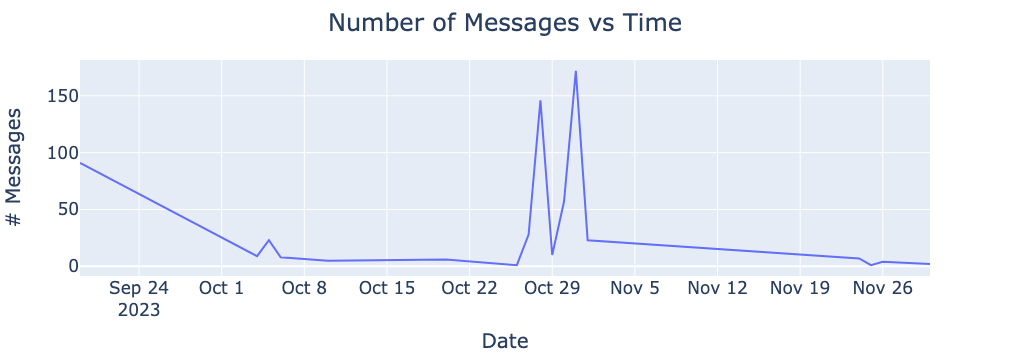

In [141]:
# Create a column of 1 to facilitate message counting
df['# Messages'] = 1

# Sum (count) the messages having the same date
date_df = df.groupby('Date').sum()
date_df.reset_index(inplace=True)

# Plot the number of messages over time
fig = px.line(date_df, x='Date', y='# Messages')

# Adjust the graph layout
fig.update_layout(
    title={'text': 'Number of Messages vs Time',
             'y':0.96,
             'x':0.5,
             'xanchor': 'center'}, 
    font=dict(
        size=17))
fig.update_xaxes(nticks=20)
fig.show()

# When adding Jupyter Notebook or IPython Notebook files with a .ipynb extension on GitHub,
# they will be displayed as static HTML files in your repository, but the plot charts will be interactive

# DOCKER COMMAND: docker run -p 8888:8888 -v /Users/cesarcadavid/Desktop/notebooks:/home/jovyan jupyter/datascience-notebook